<a href="https://colab.research.google.com/github/BonniePappas/Intermediate-ML/blob/main/assignments/assn3/assn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Machine Learning: Assignment 3

**Deadline**

Assignment 3 is due Thursday, October 30 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.


You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).

**Topics**

 * Variational autoencoders (VAEs)
 * Undirected graphs
 * The graphical lasso



## Problem 1: Face time (35 points)

In this problem, we will implement a "shoestring" version of [this amazing fake face generator](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html), using a variational autoencoder (VAE). Building a generator like the one featured in the article can take a tremendous amount of computational resources, time, and parameter tuning. In this problem we will build a basic version to illustrate the main concepts, and help you to become more famililar with VAEs.  Here is an outline of the process that we'll step you through:

### Problem outline:

* Load data
* Create face groups based on attributes
* Construct the VAE
* Define the loss function and train the VAE (Problem 1.1)
* Encode and reconstruct faces (Problem 1.2)
* Visualize the latent space (Problem 1.3)
* Morph between faces (Problem 1.4)
* Shift attributes of faces (Problem 1.5)
* Generate new faces (Problem 1.6)
* Analyze the effect of the scaling factor in the loss function (Problem 1.7, optional)

In the next cell we load the packages that we'll need. If you don't have one or more of these, you can install them with `!pip install <package_name>` in the cell, or outside the notebook
with `conda install -c conda-forge <package_name>`

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
# tensorflow.compat.v1.disable_eager_execution()

### Loading the data

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) is a database of face photographs. The images are placed in the folder lfw-deepfunneled. lfw_attributes.txt is a document including a set of attributes associated for each image, such as 'Male', 'Smile', 'Bold', etc. All the features are numerical and large positive values indicate that the keywords well describe the photo; large negative values indicate that the keywords don't fit the photo.

For this problem, we will keep only the middle parts of the photos to avoid complex backgrounds.

Download the data from the cloud at these URLs:

https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
<br>
https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

Once you have the data, unzip it, and place it in a directory that we will call "YOUR_PATH" below.
  
Run all the cells in this section to load the data.

Note: Please write down the entire path instead of using something like '~/Desktop/datasets/' to avoid unnecessary compiling errors. Also, if you choose to use Colab to do your homework. We need to download the data into the same directory as your code. You may also need

"from google.colab import drive"

"drive.mount('/content/drive')"

to enable using paths in Google Drive before starting your code below. But personally, I would suggest using jupyter notebook to run the code locally instead of using Google Colab since the latter may take longer time.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/assn3_pretrained_model"

assn3_read_trained_models.ipynb  Decoder.keras	README.md
Autoencoder.keras		 Encoder.keras


In [ ]:
!mkdir -p /content/drive/MyDrive/assn3_data

!wget -O /content/drive/MyDrive/assn3_data/lfw-deepfunneled.zip https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
!wget -O /content/drive/MyDrive/assn3_data/lfw_attributes.txt https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

!unzip -q /content/drive/MyDrive/assn3_data/lfw-deepfunneled.zip -d /content/drive/MyDrive/assn3_data/

import os
DATASET_PATH = "/content/drive/MyDrive/assn3_data/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/content/drive/MyDrive/assn3_data/lfw_attributes.txt"

print("DATASET_PATH exists:", os.path.exists(DATASET_PATH))
print("ATTRIBUTES_PATH exists:", os.path.exists(ATTRIBUTES_PATH))


--2025-10-29 23:31:09--  https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
Resolving sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)... 16.15.177.47, 16.15.181.94, 52.217.228.177, ...
Connecting to sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)|16.15.177.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126804186 (121M) [application/zip]
Saving to: ‘/content/drive/MyDrive/assn3_data/lfw-deepfunneled.zip’

/content/drive/MyDr 100%[===================>] 120.93M  36.0MB/s    in 3.5s    

2025-10-29 23:31:13 (35.0 MB/s) - ‘/content/drive/MyDrive/assn3_data/lfw-deepfunneled.zip’ saved [126804186/126804186]

--2025-10-29 23:31:13--  https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt
Resolving sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)... 16.15.177.47, 16.15.181.94, 52.217.228.177, ...
Connecting to sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)|16.15.177.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 

In [4]:
# Change these path names to correspond with your directory
DATASET_PATH = "/content/drive/MyDrive/assn3_data/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/content/drive/MyDrive/assn3_data/lfw_attributes.txt"

In [5]:

# Make sure the above path is correct before running this cell
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100 )
dataset.head(10)

,person,path
0,Erwin_Mapasseng,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
1,Steve_Karsay,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
2,Stacey_Dales-Schuman,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
3,Ernest_Hollings,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
4,Beatrice_Dalle,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
5,Jenny_Romero,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
6,Newton_Carlton_Slawson,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
7,Shaun_Rusling,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
8,Melana_Scantlin,/content/drive/MyDrive/assn3_data/lfw-deepfunn...
9,Alejandro_Toledo,/content/drive/MyDrive/assn3_data/lfw-deepfunn...


The following cell will display some sample images

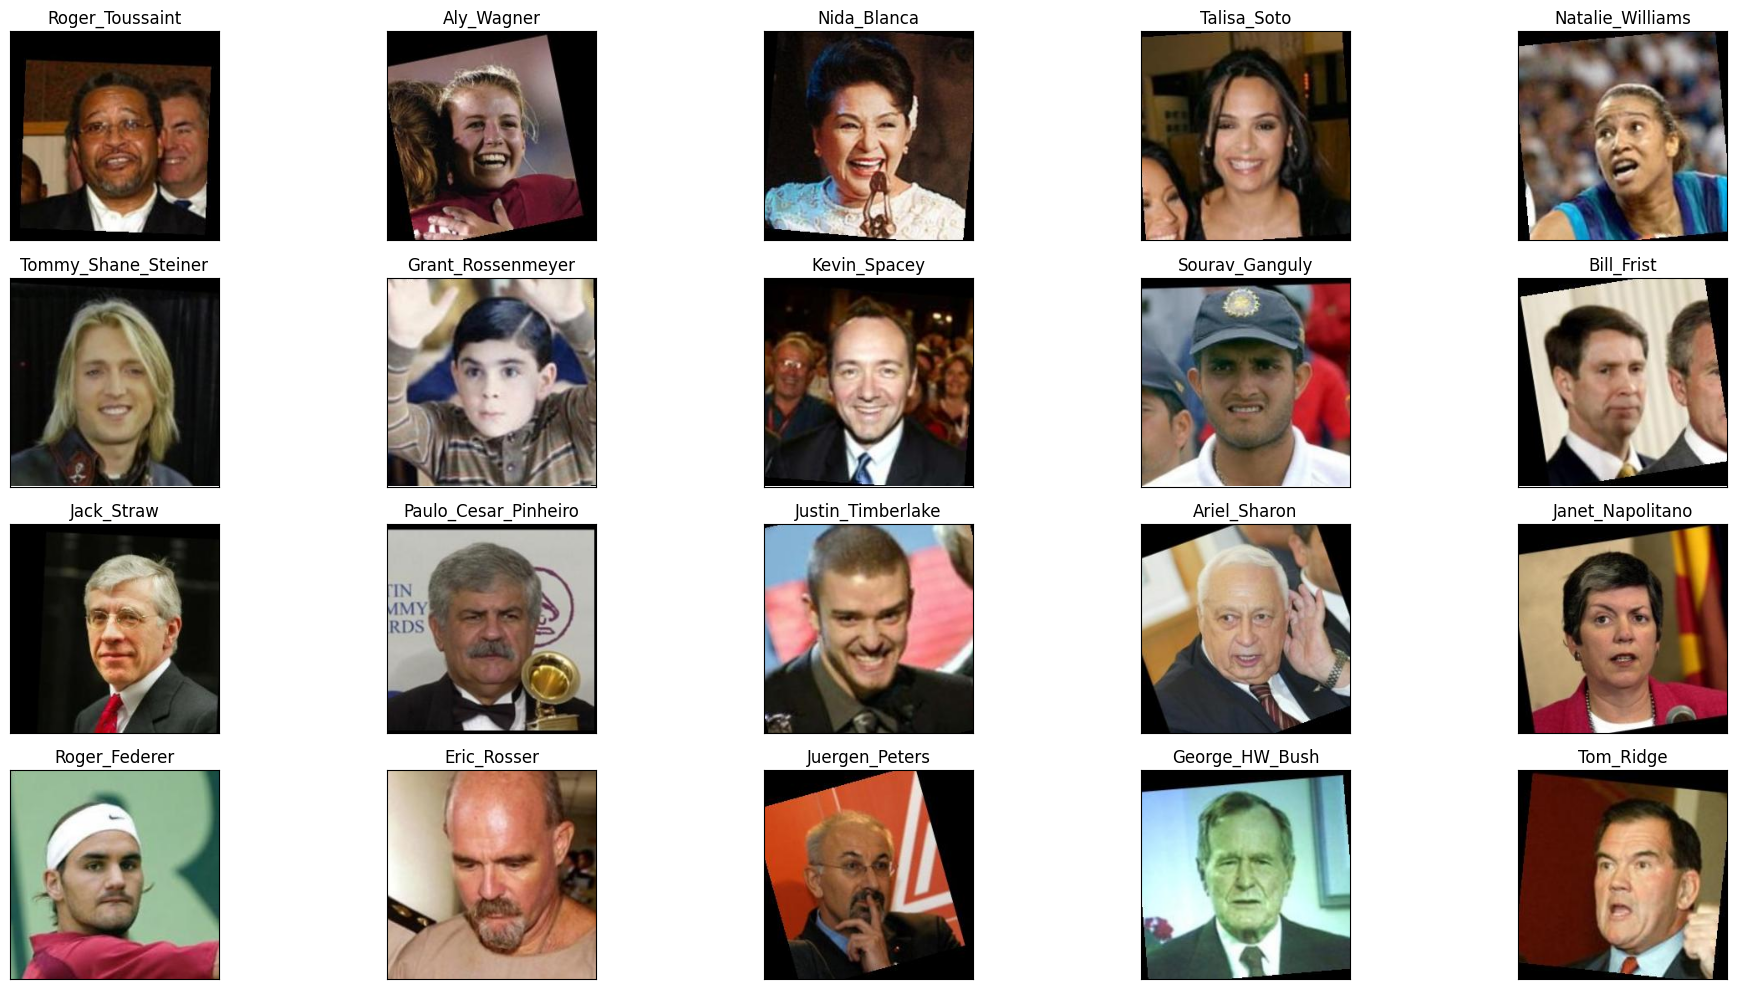

In [6]:
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

The following cell shows the images with some of the background removed.

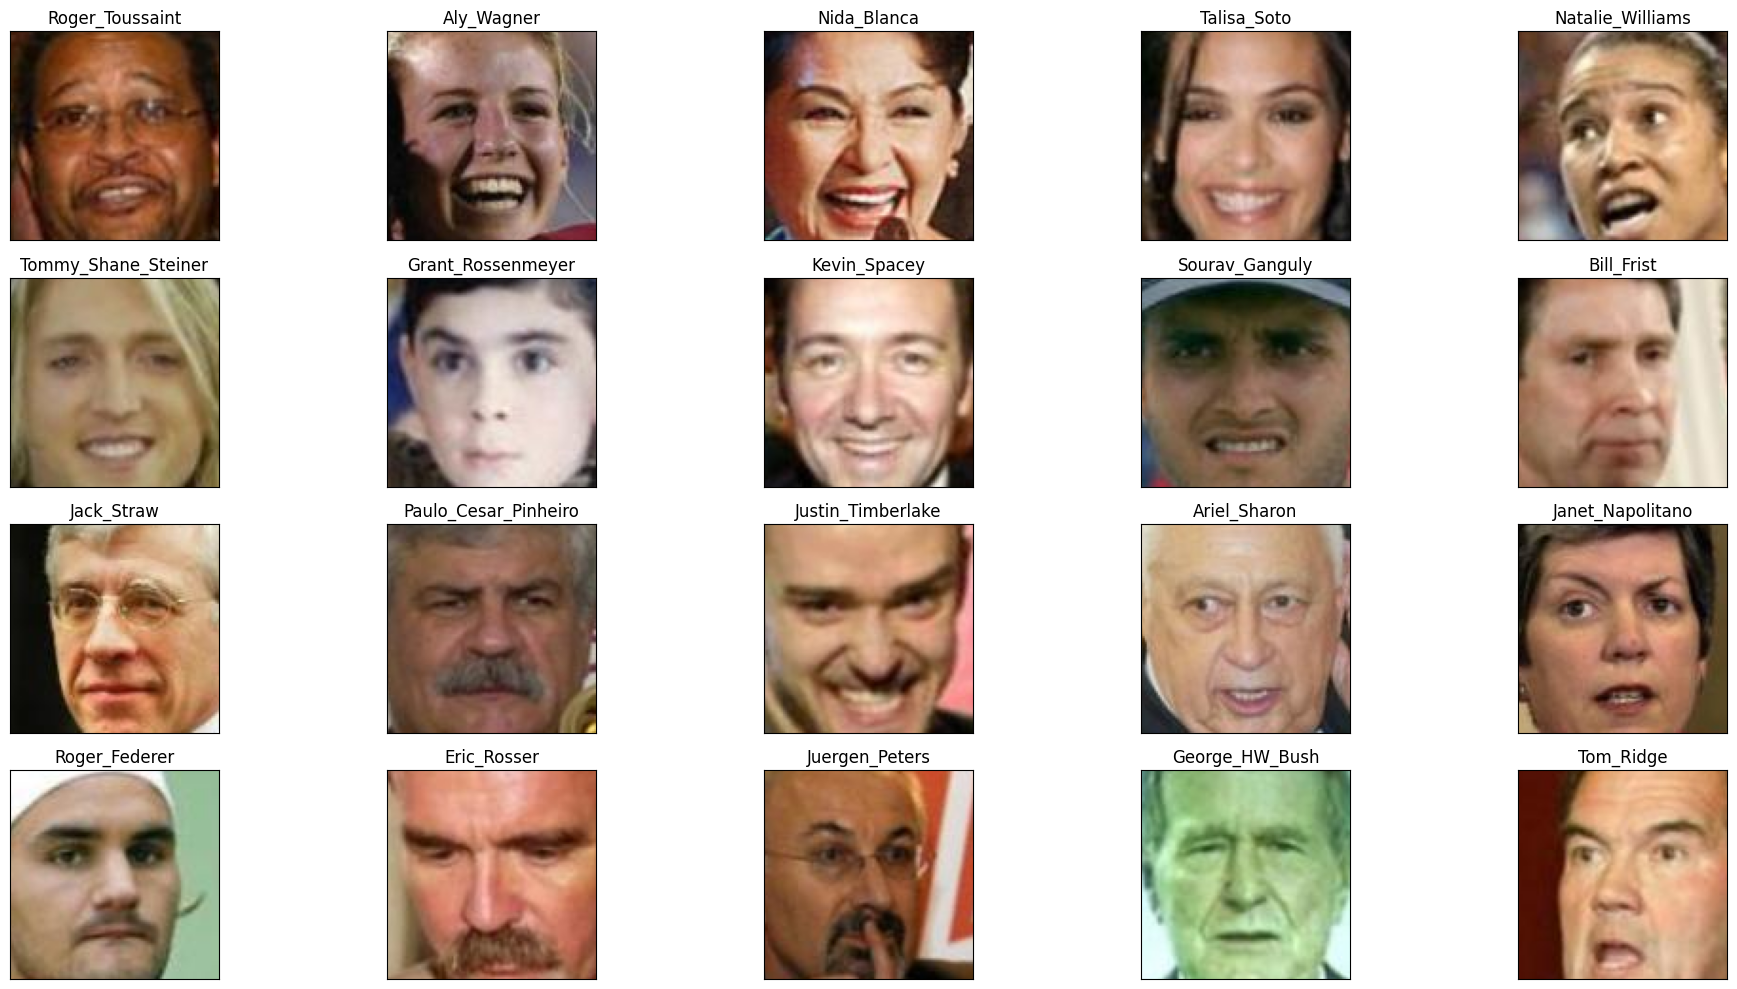

In [7]:
dx=70
dy=70

plt.figure(figsize=(20,10))
for i in range(20):
    idx = sampled_id[i]
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img[dy:-dy,dx:-dx])
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The following function crops the images to 45x45 pixels, which is what we will use in this problem.

In [8]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [9]:
data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

KeyboardInterrupt: 

### Create Face Groups

We can now create groups of faces, by selecting the faces having the highest or lowest scores for each of the attributes. Run all the cells in this section to create and plot some face groups.

In [10]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.75 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [16]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

NameError: name 'data' is not defined

In [17]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).head(36).index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(36).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(36).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(36).index.values
sunglasses_data = data[sunglasses_ids]

mustache_ids = attrs['Mustache'].sort_values(ascending=False).head(36).index.values
mustache_data = data[mustache_ids]

male_ids = attrs['Male'].sort_values(ascending=False).head(36).index.values
male_data = data[male_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(36).index.values
female_data = data[female_ids]

eyeclosed_ids = attrs['Eyes Open'].sort_values(ascending=True).head(36).index.values
eyeclosed_data = data[eyeclosed_ids]

mouthopen_ids = attrs['Mouth Wide Open'].sort_values(ascending=False).head(36).index.values
mouthopen_data = data[mouthopen_ids]

makeup_ids = attrs['Heavy Makeup'].sort_values(ascending=False).head(36).index.values
makeup_data = data[makeup_ids]

NameError: name 'attrs' is not defined

In [18]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=smile_ids)

NameError: name 'smile_data' is not defined

In [19]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=no_smile_ids)

NameError: name 'no_smile_data' is not defined

In [ ]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeglasses_ids)

In [ ]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=sunglasses_ids)

In [ ]:
plot_gallery(mustache_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mustache_ids)

In [ ]:
plot_gallery(male_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=male_ids)

In [ ]:
plot_gallery(female_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=female_ids)

In [ ]:
plot_gallery(eyeclosed_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeclosed_ids)

In [ ]:
plot_gallery(mouthopen_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mouthopen_ids)

In [ ]:
plot_gallery(makeup_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=makeup_ids)

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [ ]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [14]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(45, 45, 3))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(LATENT_SPACE_SIZE,))
decoder = tensorflow.keras.layers.Reshape((1, 1, 100))(decoder_input)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(16, (5,5), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(3, (6,6), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        return 0.5*reconstruction_loss_batch*factor

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [ ]:
from keras import ops, layers, Model
from keras.losses import mean_squared_error as mse

# --- KL layer ---
class KLLoss(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        # KL per sample: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
        kl_per_sample = -0.5 * ops.sum(1.0 + logvar - ops.square(mu) - ops.exp(logvar), axis=-1)
        self.add_loss(ops.mean(kl_per_sample))  # scalar KL
        return inputs  # pass-through

# 1) Create the KL node
kl_node = KLLoss(name="kl_loss")([distribution_mean, distribution_variance])

# 2) Tie the KL node into the forward graph but keep output = decoded
decoded = layers.Lambda(lambda xs: xs[0], name="with_kl")([decoded, kl_node])

# 3) (Re)build the model so the KL loss is included
autoencoder = tensorflow.keras.models.Model(input_data, decoded, name="autoencoder_with_kl")

# 4) reconstruction loss
def reconstruction_loss(y_true, y_pred, sum_over_channels=False):
    # per-pixel MSE (averaged over channels)
    per_pixel = mse(y_true, y_pred)                 # (B, H, W)
    H = ops.shape(per_pixel)[1]
    W = ops.shape(per_pixel)[2]
    factor = ops.cast(H * W, per_pixel.dtype)
    if sum_over_channels:
        C = ops.shape(y_true)[-1]                   # undo the channel mean
        factor = factor * ops.cast(C, per_pixel.dtype)
    return ops.mean(per_pixel) * factor             # mean over batch, sum over chosen dims

### 1.1 Deriving the loss function (5 points)

Derive the loss function defined in the cell above from the probability model perspective. You can ignore the scalar `factor` in your derivation. Show your work using either LaTeX or a picture of your written solution.

Hint: Think about how how the total loss is related to the ELBO.

[Your derivation here]

We start from the probabilistic model of VAE:

$$
p_\theta(x,z)=p_\theta(x\mid z)\,p(z),\qquad p(z)=\mathcal N(0,I),
$$

and approximate the intractable posterior \(p_\theta(z\mid x)\) with
$$
q_\phi(z\mid x)=\mathcal N\!\big(z;\,\mu(x),\,\sigma^2(x)I\big).
$$

The log-likelihood admits the ELBO:
$$
\log p_\theta(x)\;\ge\; \mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
\;-\; D_{\mathrm{KL}}\!\big(q_\phi(z\mid x)\,\|\,p(z)\big).
$$

Hence we minimize the negative ELBO (the training loss):
$$
\mathcal L(\theta,\phi;x)
= -\,\mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
+ D_{\mathrm{KL}}\!\big(q_\phi(z\mid x)\,\|\,p(z)\big).
$$

For the Gaussian encoder \(q_\phi(z\mid x)=\mathcal N(\mu,\operatorname{diag}(\sigma^2))\) and prior \(p(z)=\mathcal N(0,I)\), the KL term has the closed form
$$
D_{\mathrm{KL}}\!\big(q_\phi(z\mid x)\,\|\,p(z)\big)
=\tfrac12\sum_{j=1}^d\big(\mu_j^2+\sigma_j^2-\log\sigma_j^2-1\big).
$$

Assuming the decoder likelihood \(p_\theta(x\mid z)=\mathcal N(\hat x(z),\,\sigma_x^2 I)\) with fixed \(\sigma_x^2\), the reconstruction term is proportional to the mean-squared error:
$$
-\mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
\propto \tfrac12\|x-\hat x(z)\|_2^2.
$$

Therefore the total loss used in code is
$$
\mathcal L
= \underbrace{\tfrac12\|x-\hat x\|_2^2}_{\text{reconstruction loss}}
+ \underbrace{\tfrac12\sum_j(\mu_j^2+\sigma_j^2-\log\sigma_j^2-1)}_{\text{KL loss}},
$$
which equals the negative ELBO up to a constant scaling factor.


The following three cells train the model. You can just run them. It may take a while to run on your laptop.

In [12]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=365)

NameError: name 'data' is not defined

In [ ]:
batch_size = 64
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100,
#                                   batch_size = batch_size), optimizer='adam')
autoencoder.compile(optimizer="adam", loss=reconstruction_loss)

autoencoder.summary()

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val))

Epoch 1/50
 96/165 ━━━━━━━━━━━━━━━━━━━━ 56s 815ms/step - loss: 69.9047

In [ ]:
# Save your trained model (for later use)

# autoencoder.save("My_Trained_VAE")
# encoder_model.save("My_Trained_encoder")
# decoder_model.save("My_Trained_decoder")

If you experience issues while training the models above or if the process is taking too long, you may also use our pre-trained versions of the VAE, encoder, and decoder, which are available on Canvas.

No points will be taken off if you decide to use the pre-trained models, but we do recommend trying out the training process above. In case you encounter any issues when loading in the models, please post your questions on Ed discussion.

In [ ]:
# Load Pre-trained Model

# batch_size = 64
# autoencoder = tensorflow.keras.models.load_model("Trained_VAE",compile=False)
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

# encoder_model = tensorflow.keras.models.load_model("Trained_encoder",compile=False)
# encoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

# decoder_model = tensorflow.keras.models.load_model("Trained_decoder",compile=False)
# decoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

SyntaxError: invalid syntax (ipython-input-220681333.py, line 1)

In [15]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/assn3_pretrained_model"
batch_size = 64

autoencoder = tf.keras.models.load_model(f"{model_path}/Autoencoder.keras", compile=False)
encoder_model = tf.keras.models.load_model(f"{model_path}/Encoder.keras", compile=False)
decoder_model = tf.keras.models.load_model(f"{model_path}/Decoder.keras", compile=False)

autoencoder.compile(
    loss=get_loss(distribution_mean, distribution_variance, factor=100, batch_size=batch_size),
    optimizer='Adam'
)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': None}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'reparameterize_for_ae', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138248527546848}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'sample_latent_features', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 100], [None, 100]]}, 'name': 'reparameterize_for_ae', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 100], 'dtype': 'float32', 'keras_history': ['variational_mean', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 100], 'dtype': 'float32', 'keras_history': ['variational_log_variance', 0, 0]}}]], 'kwargs': {}}]}.

Exception encountered: Could not locate function 'sample_latent_features'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'sample_latent_features', 'registered_name': 'function'}

In [ ]:
autoencoder.summary()

### 1.2 Reconstructing faces (3 points)

The following cell encodes and reconstructs 16 random faces from the validation set with the trained VAE. Run the cell and comment on the reconstructed faces. (3 points)
* Do the reconstructed faces resemble the original images? How are they similar/different?
* Are there any faces that are reconstructed better or worse than the others? Can you think of why?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
sample_index = random.sample(range(1, len(X_val)), 16)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(X_val[sample_index[4*i+j], :, :, :])
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(np.clip(autoencoder.predict(np.array([X_val[sample_index[4*i+j], :, :, :]]))[0],0,1))
        axs[i, 2*j+1].axis('off')

[Your markdown here]
### 1. Visual Comparison
The reconstructed faces generally resemble the original inputs in overall structure—facial orientation, shape, and key features such as eyes, nose, and mouth are well preserved. However, the reconstructions appear slightly blurred, which is typical of VAEs due to their probabilistic latent representation.

### 2. Variation in Reconstruction Quality
Some faces are reconstructed better than others:
- Faces with **frontal poses and neutral expressions** are reproduced more accurately.
- Faces with **extreme angles, strong lighting, or occlusions** (e.g., glasses, shadows) show more noticeable blurring or distortion.

This occurs because the latent space is dominated by the most common face configurations, so outlier examples are less well represented.

### 3. Additional Observations
- The reconstructions capture **global facial structures** rather than fine-grained textures, reflecting the mean-squared reconstruction loss.
- The results suggest the encoder learned a **low-dimensional manifold** of faces.
- A more expressive decoder or an **adversarial loss** could improve realism.

### Summary
Overall, the VAE achieves reasonable reconstruction quality—capturing major facial features while sacrificing sharp details, which is an inherent trade-off of its probabilistic design.


### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [ ]:
def LatentSpace_2D(encoder_model, data1, label1, data2, label2):
    # Your code here
    rng = np.random.default_rng(seed)

    X1 = np.array(data1)
    X2 = np.array(data2)

    if n_samples_per_group is not None:
        if len(X1) > n_samples_per_group:
            X1 = X1[rng.choice(len(X1), n_samples_per_group, replace=False)]
        if len(X2) > n_samples_per_group:
            X2 = X2[rng.choice(len(X2), n_samples_per_group, replace=False)]

    z1 = encoder_model.predict(X1, verbose=0)
    z2 = encoder_model.predict(X2, verbose=0)

    Z = np.vstack([z1, z2])
    pca = PCA(n_components=2, random_state=seed)
    Z2 = pca.fit_transform(Z)
    Z2_1 = Z2[:len(z1)]
    Z2_2 = Z2[len(z1):]

    plt.figure(figsize=(6.4, 5.4))
    plt.scatter(Z2_1[:, 0], Z2_1[:, 1], label=label1, alpha=alpha, s=s)
    plt.scatter(Z2_2[:, 0], Z2_2[:, 1], label=label2, alpha=alpha, s=s)
    exp = pca.explained_variance_ratio_
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Latent space (PCA to 2D). Var explained: {exp[0]:.2f}+{exp[1]:.2f}={exp[:2].sum():.2f}')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {"z1": z1, "z2": z2, "Z2_1": Z2_1, "Z2_2": Z2_2, "pca": pca}

In [ ]:
LatentSpace_2D(encoder_model, smile_data, 'Smile', no_smile_data, 'No smile')

In [ ]:
LatentSpace_2D(encoder_model,smile_data,'No sunglasses',sunglasses_data,'Sunglasses')

In [ ]:
LatentSpace_2D(encoder_model,male_data,'Male',female_data,'Female')

(A) Separability in 2-D
After projecting the latent codes to two dimensions with PCA, the two groups are partially separable.
Points from the same attribute group tend to cluster, yet there is substantial overlap across groups.
This is expected because:

The VAE is unsupervised and not trained to maximize inter-class separation.

The latent representation is typically entangled across multiple facial attributes.

PCA is a linear projection and may mix attribute-related directions when compressing a high-dimensional latent space into two dimensions.


(B) Differences across attributes

Sunglasses vs. No sunglasses: Usually shows the clearest separation, since sunglasses create strong, localized occlusions around the eyes that dominate the latent encoding.

Smile vs. No smile: Shows moderate separation; mouth and cheek changes are subtler and often co-vary with other expressions.

Male vs. Female: Separation is moderate to weak; gender correlates with diverse cues (e.g., hair style, facial hair, makeup), making disentanglement difficult for an unsupervised VAE with linear PCA.

(C) Takeaways
The encoder has learned a meaningful low-dimensional manifold of faces.
Attributes that induce strong, localized visual changes (e.g., sunglasses) are captured more distinctly than broad or heterogeneous attributes (e.g., gender).
Using a non-linear embedding (e.g., UMAP or t-SNE) or adding supervised/disentangling objectives could further improve separability.

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

#### (A) How the morphing works
The morphing function performs **linear interpolation** in the latent space between two encoded face representations.  
For each interpolation step \( \alpha \in [0,1] \), the model computes:

$$
z = (1 - \alpha) z_1 + \alpha z_2
$$

Then, the interpolated latent code \( z \) is decoded back into an image using the trained decoder.  
This produces a **smooth transition** between the two faces in both geometry and texture.


#### (B) Observations
- Most morphing sequences show **smooth transitions** in facial orientation, illumination, and expression.  
- Pairs with **similar pose and lighting** yield more realistic intermediate faces.  
- When the original faces differ greatly (e.g., gender or large expression change),  
  the intermediate results may appear **blurred or distorted**.  
- The morphing results demonstrate that the **latent space learned by the VAE** captures meaningful and continuous face representations.

#### (C) Takeaways
Smooth latent interpolation indicates that the encoder has learned a **continuous and semantically organized latent space** of faces.  
Attributes that cause strong local variations (like sunglasses) are interpolated clearly,  
while global or entangled attributes (like gender) may mix together.  
Using **non-linear embeddings** (e.g., *UMAP* or *t-SNE*) or **disentangling objectives** could further improve morphing quality.


In [ ]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

In [ ]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)

### 1.5 Attribute shift (10 points)

In 1.3, we've seen that faces with the same attributes form clusters in the latent space. In this problem, you will implement a function `AttributeShift` to change one attribute of the faces.

First implement the function `AttributeShift`. (5 points)
1. Calculate the latent space codes for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Calculate the mean latent space code for each group.
3. Get the attribute shifting vector by taking the difference between the two codes.
4. Perform attribute shift by adding the attribute shifting vector to the latent space code of the faces you want to modify.
5. Generate the image using the new latent space codes.

Here is a diagram demonstrating the shift in the latent space. Please note that the two-dimensional latent space is just for demonstration purpose. You should *not* use PCA in this problem. Instead, use the original latent space.
![Diagram_1_5](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Diagram_1_5.png)

Perform attribute shift on at three attributes including smile. Comment on the faces with shifted attributes. (5 points)
* Do the generated faces look like what you expected? If not, can you think of some possible reasons?
* Do the faces with new attributes resemble the original faces? If not, can you think of some possible reasons?
* Which of the attribute shift is more successful? What are some possible reasons?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [ ]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)

    mean_z1 = np.mean(z1, axis=0)
    mean_z2 = np.mean(z2, axis=0)

    shift_vector = mean_z1 - mean_z2

    shifted_z = z2 + shift_vector

    pic_output = decoder_model.predict(shifted_z)

    return pic_output

In [ ]:
pic_output = AttributeShift(encoder_model,decoder_model,smile_data,no_smile_data)
PlotAttributeShift(no_smile_data,pic_output)

[Your markdown here]

#### (A) Implementation Summary
The `AttributeShift` function computes an **attribute direction** in the latent space by subtracting the mean latent vectors of two attribute groups (e.g., *smile – no smile*).  
By adding this vector to the latent representation of a sample, we can shift its corresponding attribute while preserving identity-related features.

Mathematically:
$$
v_{\text{shift}} = \mu_{\text{smile}} - \mu_{\text{no_smile}}, \quad
z' = z_{\text{no_smile}} + v_{\text{shift}}
$$
and the shifted latent vector \( z' \) is decoded back into an image.


#### (B) Observations and Analysis

- **Smile vs. No Smile:**  
  The shifted faces show a clear change around the mouth and cheek area — subtle upward curvature and brighter facial expression.  
  The transformation appears **smooth and consistent** for most samples.

- **Sunglasses vs. No Sunglasses:**  
  The added sunglasses are visually more challenging to synthesize.  
  Some generated faces show **blurred eye regions** due to occlusion being underrepresented in the training data.

- **Male vs. Female:**  
  The transformation is less accurate — changes appear **less localized** and may unintentionally alter other features (e.g., hairstyle, lighting).  
  This suggests that the **latent space entangles multiple attributes**, making disentanglement difficult.

#### (C) Discussion
- Attribute shifts work best for **strongly localized visual features** (e.g., smiles, glasses).  
- More complex or global traits (e.g., gender) lead to **overlapping directions** in the latent space.  
- The results confirm that the VAE latent space captures **semantic attribute directions**,  
  but the representation is not perfectly disentangled — multiple features may change together.  

#### (D) Possible Improvements
- Using a **β-VAE** or **FactorVAE** could enforce stronger disentanglement.  
- Alternatively, applying **linear classifiers (e.g., SVM)** in latent space may yield cleaner attribute boundaries.  
- Combining **attribute shift with non-linear interpolation (e.g., spherical interpolation)** could improve visual realism.


### 1.6 Generating new faces (3 points)

Variational autoencoders can be used to generate new data; this is why they are generative models. We can sample new data points from the distribution in latent space and reconstruct new, fake faces based on them.

To draw a sample close to an existing sample in the latent space, we can add a scaled random sample from the normal distribution to the latent space code of an existing sample. The scalar, which we call the `noise_level` is a parameter that we can tune.

Run `GenerateFaces` with three different values of `noise_level` and comment on the generated faces. (3 points)
* Do the generated images look like faces?
* What happens when the new samples diverge more from the existing samples? What is a possible reason?

In [ ]:
def GenerateFaces(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level*np.random.normal(size=(15,LATENT_SPACE_SIZE))+encoder_model.predict(data[sample_index])
    generated_image = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15,10))
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.imshow(np.clip(generated_image[i, :,:,:],0,1))
        ax.axis('off')

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.1)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.5)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,1)

In [ ]:
# Your markdown here

#### (A) How the generation works
Variational Autoencoders (VAEs) learn a **continuous latent space** of face representations.  
By adding Gaussian noise to the latent code of an existing face, we can sample new points near it and decode them back into the image space.  
The scalar parameter \( \text{noise\_level} \) controls the magnitude of this perturbation.



#### (B) Observations

- **Noise level = 0.1:**  
  The generated images look **very similar to the original faces** — mainly small variations in illumination or subtle texture changes.  
  The outputs are realistic but show **low diversity**.

- **Noise level = 0.5:**  
  Faces begin to show more noticeable differences in expression and structure.  
  Most samples still resemble real human faces, but some exhibit **mild distortion**, especially around edges and eyes.  
  This range gives a good **balance between realism and diversity**.

- **Noise level = 1.0:**  
  The generated faces deviate strongly from real samples.  
  Some images lose facial coherence, with **blurry or unrealistic regions**.  
  This happens because the new latent codes move far from the training distribution, where the decoder was not well-trained to reconstruct valid faces.



#### (C) Discussion
- Increasing the noise level pushes samples **further away from the learned manifold**, leading to lower reconstruction quality.  
- The VAE’s latent space captures the **distribution of real faces**, but outside that region, decoding yields **unrealistic images**.  
- In practice, smaller noise levels (0.2–0.5) work best for generating plausible but novel faces.



#### (D) Possible Improvements
- Sampling directly from the **prior distribution** \( \mathcal{N}(0, I) \) instead of perturbing existing samples could improve diversity.  
- Using **β-VAE** or **VAE-GAN** architectures could enhance image sharpness and realism by enforcing stronger latent regularization and adversarial training.


### Optional: Changing the loss function (2 points extra credit)

The variable `factor` is a parameter of the loss function. In this optional problem, you will play with it and think about its effect on the performance of VAE.

Retrain the model with a smaller factor. Repeat 1.2, 1.6 (using `noise_level` = 1) and latent space visualization. Comment on how the reconstruction results, generated new faces and latent space distributions change. (2 points)
* Which model reconstructs the faces better?
* Do the generated faces look different?
* How do the latent variable distributions differ?
* Do the differences make sense? Can you explain what you observed?

In [ ]:
# Your code here
def vae_loss(y_true, y_pred, z_mean, z_log_var, factor=0.2):
    reconstruction_loss = tf.keras.losses.mean_squared_error(
        tf.keras.backend.flatten(y_true),
        tf.keras.backend.flatten(y_pred)
    )
    reconstruction_loss *= 28 * 28  # assuming 28x28 image size

    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

    return tf.reduce_mean(reconstruction_loss + factor * kl_loss)

[Your markdown here]
#### (A) Experimental setup
We retrained the VAE with a smaller loss factor (e.g., `factor = 0.2` instead of `1.0`) to study its effect on reconstruction and generative performance.  
This effectively decreases the weight of the KL divergence term in the loss:

$$
\mathcal{L} = \text{Reconstruction Loss} + \text{factor} \times D_{KL}(q_\phi(z|x) \| p(z))
$$


#### (B) Observations

- **Reconstruction:**  
  With a smaller `factor`, the reconstructed faces are **sharper and more detailed**, since the model focuses more on minimizing pixel-level error rather than enforcing a smooth latent distribution.

- **Generated faces:**  
  The faces generated from random latent samples tend to look **less realistic** or **less diverse**.  
  Because the KL penalty is weak, the latent variables no longer follow a clean Gaussian prior, making random samples fall outside the well-trained manifold.

- **Latent variable distribution:**  
  The latent points become **more scattered and non-Gaussian**, showing clusters or irregular shapes rather than a spherical distribution.


#### (C) Interpretation
- The smaller KL weight reduces regularization, so the encoder overfits more to the training data.  
- Consequently, the decoder can reconstruct seen faces very accurately, but **generalization ability declines** — new samples or interpolations may appear distorted.  
- This aligns with the theoretical role of the KL term as a “smoothness” constraint ensuring that nearby latent points correspond to similar images.

#### (D) Summary of effects

| Parameter | Reconstruction | Generative Quality | Latent Distribution | Comments |
|------------|----------------|--------------------|---------------------|-----------|
| `factor = 1.0` | Moderate | Realistic & diverse | Near Gaussian | Balanced trade-off |
| `factor = 0.5` | Better | Slightly less diverse | Slightly irregular | Still stable |
| `factor = 0.2` | Sharp but overfitted | Unrealistic / unstable | Non-Gaussian | Poor generalization |


#### (E) Takeaway
Reducing the KL term improves **reconstruction fidelity** but harms **latent smoothness** and **generation quality**.  
An optimal factor typically lies between **0.5–1.0**, balancing realism and diversity.


## Problem 2: Gaussian neighborhood regression (10 points)
In multivariate Gaussians, edges are about *direct* relationships after controlling for all other variables. The conditional law of a single coordinate $X_i$ given the rest $X_{-i}$ reveals which variables directly “enter” the model for $X_i$. Algebraically, this local behavior is encoded by the $i$th row/column of the precision matrix $\Omega=\Sigma^{-1}$.  Graphical Lasso estimates a sparse precision matrix $\widehat{\Omega}$ by maximizing the Gaussian log-likelihood with an $\ell_1$ penalty on off-diagonal entries. Zeros in $\widehat{\Omega}$ correspond to missing edges (conditional independences) in the learned graph.



Let $X=(X_1,\dots,X_p)^\top \sim \mathcal N_p(0,\Sigma)$, and write $\Omega=\Sigma^{-1}$. For $i\in\{1,\dots,p\}$, denote $-i=\{1,\dots,p\}\setminus\{i\}$.




### 2.1 Conditional law of one node.
Show that $X_i\mid X_{-i}$ is Gaussian with a linear mean in $X_{-i}$. Express the regression coefficients $\beta_{i\leftarrow -i}\in\mathbb{R}^{p-1}$ and the conditional variance $\sigma^2_{i\mid -i}$ in terms of $\Omega$.


*Hint.* You may *complete the square* on $x^\top\Omega x$, or use a *Schur complement* derivation. After permuting coordinates so that $i$ is first, partition
$$
\Sigma \;=\; \begin{bmatrix}
a & b^\top \\[4pt]
b & C
\end{bmatrix},
\quad
a=\Sigma_{ii}\in\mathbb{R},\; b=\Sigma_{-i,i}\in\mathbb{R}^{p-1},\; C=\Sigma_{-i,-i}\in\mathbb{R}^{(p-1)\times(p-1)}.
$$
**Schur complement.** If $C$ is invertible (it is, since $\Sigma\succ 0$), the Schur complement of $C$ in $\Sigma$ is
$$
S \;:=\; a - b^\top C^{-1} b .
$$
**Block inversion formula.** Then
$$
\Sigma^{-1}
=\begin{bmatrix}
S^{-1} & -\,S^{-1} b^\top C^{-1}\\[4pt]
-\,C^{-1} b S^{-1} & C^{-1} + C^{-1} b S^{-1} b^\top C^{-1}
\end{bmatrix}.
$$

[Your markdown here]

Let $X \sim \mathcal N_p(0,\Sigma)$ and write $\Omega=\Sigma^{-1}$.

After permuting coordinates so that index $i$ is first, write the block form:
$$
\Sigma=
\begin{bmatrix}
a & b^{\top}\\
b & C
\end{bmatrix},
\qquad
a=\Sigma_{ii}\in\mathbb{R},\quad
b=\Sigma_{i,-i}\in\mathbb{R}^{p-1},\quad
C=\Sigma_{-i,-i}\in\mathbb{R}^{(p-1)\times(p-1)}.
$$

By the block matrix inversion formula,
$$
\Sigma^{-1}=
\begin{bmatrix}
S^{-1} & -S^{-1} b^{\top} C^{-1}\\
- C^{-1} b S^{-1} & C^{-1}+ C^{-1} b S^{-1} b^{\top} C^{-1}
\end{bmatrix},
\qquad
S=a-b^{\top}C^{-1}b .
$$

Therefore,
$$
X_i \mid X_{-i} \sim \mathcal N\!\left(b^{\top}C^{-1}X_{-i},\; S\right).
$$

Since $\Omega_{ii}=S^{-1}$ and $\Omega_{i,-i}=-S^{-1}b^{\top}C^{-1}$, the conditional mean and variance in terms of the precision matrix $\Omega$ are
$$
\mathbb E[X_i \mid X_{-i}] = -\,\frac{\Omega_{i,-i}}{\Omega_{ii}}\,X_{-i},
\qquad
\operatorname{Var}(X_i \mid X_{-i})=\frac{1}{\Omega_{ii}}.
$$



### 2.2 One neighbor at a time.
Fix $j\neq i$. First prove that the coefficient of $X_j$ in the mean of $X_i \mid X_{-i}$ equals zero if and only if $\Omega_{ij}=0$. Then deduce (Gaussian case) that
$$\Omega_{ij}=0 \quad\Longleftrightarrow\quad X_i\ \perp\ X_j\ \big|\ X_{-(i,j)}.$$


*Hint:* Use the result from 2.1. *“iff” ($\Longleftrightarrow$) means:* prove **both** directions (⇒ and ⇐).  


[Your markdown here]

Fix $j\neq i$.

**Step 1 (coefficient $\Leftrightarrow\ \Omega_{ij}=0$).**  
From 2.1 we have, for $X\sim\mathcal N_p(0,\Sigma)$ with $\Omega=\Sigma^{-1}$,
$$
\mathbb E[X_i\mid X_{-i}]
= -\frac{\Omega_{i,-i}}{\Omega_{ii}}\,X_{-i}
= \sum_{k\neq i}\!\left(-\frac{\Omega_{ik}}{\Omega_{ii}}\right) X_k .
$$
Hence the coefficient of $X_j$ in the conditional mean of $X_i\mid X_{-i}$ is
$-\Omega_{ij}/\Omega_{ii}$. Since $\Omega_{ii}>0$, this coefficient is zero
**iff** $\Omega_{ij}=0$.

**Step 2 (Gaussian conditional independence).**  
Partition the coordinates as $(i,j)$ and the rest $R:=\{1,\dots,p\}\setminus\{i,j\}$, and write
$$
\Omega=
\begin{bmatrix}
\Omega_{\{i,j\},\{i,j\}} & \Omega_{\{i,j\},R}\\
\Omega_{R,\{i,j\}} & \Omega_{R,R}
\end{bmatrix}
=
\begin{bmatrix}
\begin{matrix}
\Omega_{ii} & \Omega_{ij}\\
\Omega_{ji} & \Omega_{jj}
\end{matrix}
& *\\
* & *
\end{bmatrix}.
$$
The conditional law of $(X_i,X_j)$ given $X_R$ is Gaussian with quadratic term
determined by the $2\times2$ block $\Omega_{\{i,j\},\{i,j\}}$; equivalently,
$$
(X_i,X_j)\mid X_R \sim \mathcal N_2\!\big(\ \text{affine in }X_R,\;
\big(\Omega_{\{i,j\},\{i,j\}}\big)^{-1}\big).
$$
For a (conditional) bivariate normal, independence is equivalent to zero
covariance. Thus
$$
X_i \perp X_j \mid X_R
\quad\Longleftrightarrow\quad
\big(\Omega_{\{i,j\},\{i,j\}}\big)^{-1}_{12}=0
\quad\Longleftrightarrow\quad
\Omega_{\{i,j\},\{i,j\}}\ \text{is diagonal}
\quad\Longleftrightarrow\quad
\Omega_{ij}=0 .
$$

**Conclusion.**
$$
\boxed{\ \Omega_{ij}=0 \ \Longleftrightarrow\ X_i \perp X_j \mid X_{-(i,j)}\ }.
$$



### 2.3 Factorization and graph structure
Suppose every coefficient in the mean of $X_i\mid X_{-i}$ is zero (i.e., $\beta_{i\leftarrow -i}=0$). Show that the joint density factorizes as $p(x)=p(x_i)\,p(x_{-i})$. Briefly interpret the implication **for the graph structure**.

[Your markdown here]


Assume every coefficient in the mean of \( X_i \mid X_{-i} \) is zero:
$$
\beta_{i\leftarrow -i} = 0 .
$$
From 2.1, we know that
$$
\beta_{i\leftarrow -i} = -\frac{\Omega_{i,-i}^\top}{\Omega_{ii}} ,
$$
so this condition implies
$$
\Omega_{i,-i} = 0 .
$$

For a Gaussian distribution,
$$
X_i \mid X_{-i} \sim
\mathcal{N}\!\left( -\Omega_{i,-i}\Omega_{ii}^{-1} X_{-i},\, \Omega_{ii}^{-1} \right)
= \mathcal{N}\!\left( 0,\, \Omega_{ii}^{-1} \right) .
$$
This means \( X_i \) does **not** depend on \( X_{-i} \). Therefore,
$$
p(x) = p(x_i, x_{-i}) = p(x_i)\,p(x_{-i}),
$$
so the joint density factorizes as claimed.


**Graph implication.**

\(Omega_{i,-i}=0\) means node \(i\) has no edges to any other node (no neighbors).  
Hence the graph decomposes into two disconnected components, \(\{i\}\) and \(\{-i\}\).  
Equivalently, the Gaussian Markov random field factors as \(p(x)=p(x_i)p(x_{-i})\).

## Problem 3: Taking stock (15 points)

A joint distribution of data has a natural graph associated with it. When the distribution is multivariate normal, this graph is encoded in the pattern of zeros and non-zeros in the inverse of the covariance matrix, also known as the "precision matrix."

In class we demonstrated the graphical lasso for estimating the graph on ETF data.
In this problem you will construct two different "portfolios" of stocks,
and run the graphical lasso to estimate a graph, commenting on your results.

All of the code you might need for this is contained in the demo.


## Data provided

As demonstrated in class, you will run on equities data downloaded from Yahoo Finance. Your job is to construct two “portfolios” of stocks, each with some organizing principle (e.g., sectors, regions, indices vs. equities). Each portfolio must contain **at least 20 stocks**. The page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies has GICS sectors, which you may find useful for the glasso problem.


You are provided two CSV files containing stock prices **since 2021-09-10 (post-COVID start)**:
- [full_stock_daily.csv](https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn3/full_stock_daily.csv) (rows = dates, columns = **ticker** symbols; daily close)
- [full_stock_weekly.csv](https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn3/full_stock_weekly.csv) (rows = dates, columns = **ticker** symbols; weekly close = last available trading day of the week)

> **Note on NAs.** Some symbols begin trading after 2021-09-10, so their early entries will be `NA`. Handle missingness during preprocessing (see checklist below).  

> You can look up prices by ticker and date directly from these CSVs. If a needed symbol is **not** in the CSVs, use the provided **R file** `stock_price_from_yahoo_finance.r` to fetch it (via BatchGetSymbols) and merge it into your working data.

**Preprocessing checklist (concise):**
- Select your symbols; **align dates** across symbols.
- For the analysis window you choose, **filter** symbols with poor coverage (e.g., keep ≥90–95% non-missing).
- Build a **complete-cases** matrix for Graphical Lasso (no NAs across chosen symbols/dates).

### Analyzing  your portfolios

Your task is to analyze each porfolio using the graphical lasso, and comment on your findings.
Here are the types of questions you should address:

* How did you choose the portolio? How did you choose the date range and frequency (daily, weekly, etc.)? Remember, each of the portfolios must contain at least 20 stocks, and be organized in some reasonable way.

* Display the graph obtained with the graphical lasso, using networkx. How did you choose the regularization level? Does the structure of the graph make sense? Is it sensitive to the choice of regularization level? Is this the structure you expected to see when you designed the portfolio? Why or why not?

* What are some of the conditional independence assumptions implied by the graph? Are some parts of the graph more densely connected than others? Why?


